In [1]:
import gym
import random
import numpy as np
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from statistics import median, mean
from collections import Counter

LR = 1e-3
env = gym.make("CartPole-v0")
env.reset()
goal_steps = 500
score_requirement = 50
initial_games = 10000

Instructions for updating:
Colocations handled automatically by placer.


In [2]:
#env.close()
def some_random_games_first():
    # Each of these is its own game.
    for episode in range(10):
        env.reset()
        # this is each frame, up to 200...but we wont make it that far.
        for t in range(2000):
            # This will display the environment
            # Only display if you really want to see it.
            # Takes much longer to display it.
            env.render()
            
            # This will just create a sample action in any environment.
            # In this environment, the action can be 0 or 1, which is left or right
            action = env.action_space.sample()
            
            # this executes the environment with an action, 
            # and returns the observation of the environment, 
            # the reward, if the env is over, and other info.
            observation, reward, done, info = env.step(action)
            if done:
                break
        env.close()
                
some_random_games_first()


In [3]:
def initial_population():
    # [OBS, MOVES]
    training_data = []
    # all scores:
    scores = []
    # just the scores that met our threshold:
    accepted_scores = []
    # iterate through however many games we want:
    for _ in range(initial_games):
        score = 0
        # moves specifically from this environment:
        game_memory = []
        # previous observation that we saw
        prev_observation = []
        # for each frame in 200
        for _ in range(goal_steps):
            # choose random action (0 or 1)
            action = random.randrange(0,2)
            # do it!
            observation, reward, done, info = env.step(action)
            
            # notice that the observation is returned FROM the action
            # so we'll store the previous observation here, pairing
            # the prev observation to the action we'll take.
            if len(prev_observation) > 0 :
                game_memory.append([prev_observation, action])
            prev_observation = observation
            score+=reward
            if done: break

        # IF our score is higher than our threshold, we'd like to save
        # every move we made
        # NOTE the reinforcement methodology here. 
        # all we're doing is reinforcing the score, we're not trying 
        # to influence the machine in any way as to HOW that score is 
        # reached.
        if score >= score_requirement:
            accepted_scores.append(score)
            for data in game_memory:
                # convert to one-hot (this is the output layer for our neural network)
                if data[1] == 1:
                    output = [0,1]
                elif data[1] == 0:
                    output = [1,0]
                    
                # saving our training data
                training_data.append([data[0], output])

        # reset env to play again
        env.reset()
        # save overall scores
        scores.append(score)
    
    # just in case you wanted to reference later
    training_data_save = np.array(training_data)
    np.save('saved.npy',training_data_save)
    
    # some stats here, to further illustrate the neural network magic!
    print('Average accepted score:',mean(accepted_scores))
    print('Median score for accepted scores:',median(accepted_scores))
    print(Counter(accepted_scores))
    
    return training_data

In [4]:
def neural_network_model(input_size):

    network = input_data(shape=[None, input_size, 1], name='input')

    network = fully_connected(network, 128, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 256, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 512, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 256, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 128, activation='relu')
    network = dropout(network, 0.8)

    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')
    model = tflearn.DNN(network, tensorboard_dir='log')

    return model


def train_model(training_data, model=False):

    X = np.array([i[0] for i in training_data]).reshape(-1,len(training_data[0][0]),1)
    y = [i[1] for i in training_data]

    if not model:
        model = neural_network_model(input_size = len(X[0]))
    
    model.fit({'input': X}, {'targets': y}, n_epoch=5, snapshot_step=500, show_metric=True, run_id='openai_learning')
    return model

In [5]:
training_data = initial_population()

/home/toufik/anaconda3/envs/workshop/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: You are calling 'step()' even though this environment has already returned done = True. You should always call 'reset()' once you receive 'done = True' -- any further steps are undefined behavior.
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Average accepted score: 61.31266846361186
Median score for accepted scores: 57.0
Counter({50.0: 36, 51.0: 34, 52.0: 29, 53.0: 26, 54.0: 25, 57.0: 16, 55.0: 16, 61.0: 15, 58.0: 13, 62.0: 13, 56.0: 11, 64.0: 10, 63.0: 9, 60.0: 9, 72.0: 8, 65.0: 7, 59.0: 7, 67.0: 6, 70.0: 6, 68.0: 6, 66.0: 5, 78.0: 5, 73.0: 4, 84.0: 4, 76.0: 4, 82.0: 3, 80.0: 3, 87.0: 3, 75.0: 3, 77.0: 3, 71.0: 3, 88.0: 3, 69.0: 3, 79.0: 3, 81.0: 2, 103.0: 2, 93.0: 2, 74.0: 2, 85.0: 2, 105.0: 1, 99.0: 1, 147.0: 1, 90.0: 1, 86.0: 1, 98.0: 1, 97.0: 1, 131.0: 1, 89.0: 1, 83.0: 1})


In [6]:
model = train_model(training_data)

Training Step: 1749  | total loss: 0.66026 | time: 2.483s
| Adam | epoch: 005 | loss: 0.66026 - acc: 0.6213 -- iter: 22336/22376
Training Step: 1750  | total loss: 0.66599 | time: 2.491s
| Adam | epoch: 005 | loss: 0.66599 - acc: 0.6092 -- iter: 22376/22376
--


In [7]:
scores = []
choices = []
for each_game in range(10):
    score = 0
    game_memory = []
    prev_obs = []
    env.reset()
    for _ in range(goal_steps):
        env.render()

        if len(prev_obs)==0:
            action = random.randrange(0,2)
        else:
            action = np.argmax(model.predict(prev_obs.reshape(-1,len(prev_obs),1))[0])

        choices.append(action)
                
        new_observation, reward, done, info = env.step(action)
        prev_obs = new_observation
        game_memory.append([new_observation, action])
        score+=reward
        if done: break

    scores.append(score)
print('Average Score:',sum(scores)/len(scores))
print('choice 1:{}  choice 0:{}'.format(choices.count(1)/len(choices),choices.count(0)/len(choices)))
print(score_requirement)
env.close()

Average Score: 200.0
choice 1:0.4995  choice 0:0.5005
50


MOUNTAIN CAR

In [8]:
import itertools
import numpy as np
import gym
np.random.seed(0)
env = gym.make('MountainCar-v0')
env.seed(0)

[0]

In [9]:
import random
class Agent:
    def decide(self, observation, rand= False):
        position, velocity = observation
        lb = min(-0.09 * (position + 0.25) ** 2 + 0.03,
                0.3 * (position + 0.9) ** 4 - 0.008)
        ub = -0.07 * (position + 0.38) ** 2 + 0.07
        if lb < velocity < ub:
            action = 2 # push right
        else:
            action = 0 # push left
        if rand:
            action = random.choice([0, 2])
        return action

agent = Agent()

In [12]:
def play_once(env, agent, render=False, verbose=False):
    observation = env.reset()
    episode_reward = 0.
    for step in itertools.count():
        if render:
            env.render()
        action = agent.decide(observation, rand= True)
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            break
    if verbose:
        print('get {} rewards in {} steps'.format(
                episode_reward, step + 1))
    return episode_reward

In [13]:
episode_rewards = [play_once(env, agent) for _ in range(100)]
print('average episode rewards = {}'.format(np.mean(episode_rewards)))

average episode rewards = -200.0


In [14]:
for i in range(5):
    episode_rewards = play_once(env, agent, render=True)
#print('average episode rewards = {}'.format(np.mean(episode_rewards)))
env.close()

In [15]:
# using sarsa lemda
%matplotlib inline
import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

In [16]:
class TileCoder:
    def __init__(self, layers, features):
        """ 
        Parameters
        - layers: int, the number of layers in tile coding
        - features: int, the number of features, also the shape of weights
        """
        self.layers = layers
        self.features = features
        self.codebook = {}
    
    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count = len(self.codebook)
        if count >= self.features: # collide when codebook is full
            return hash(codeword) % self.features
        else:
            self.codebook[codeword] = count
            return count
        
    def __call__(self, floats=(), ints=()):
        """ 
        Parameters
        - floats: tuple of floats, each of which is within [0., 1.]
        - ints: tuple of ints
        Returns
        - features : list of ints
        """
        dim = len(floats)
        scaled_floats = tuple(f * self.layers * self.layers for f in floats)
        features = []
        for layer in range(self.layers):
            codeword = (layer,) + tuple(int((f + (1 + dim * i) * layer) / self.layers) \
                    for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

In [17]:
class SARSAAgent:
    def __init__(self, env, layers=8, features=2000, gamma=1.,
                learning_rate=0.03, epsilon=0.001):
        self.action_n = env.action_space.n
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - env.observation_space.low
        self.encoder = TileCoder(layers, features)
        self.w = np.zeros(features)
        self.gamma = gamma
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        
    def encode(self, observation, action):
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)
    
    def get_q(self, observation, action):
        features = self.encode(observation, action)
        return self.w[features].sum()
    
    def decide(self, observation):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in range(self.action_n)]
            return np.argmax(qs)
        
    def learn(self, observation, action, reward, observation_next, done, action_next=None):
        u = reward
        if not done:
            u += (self.gamma * self.get_q(observation_next, action_next))
        delta = u - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += (self.learning_rate * delta)


class SARSALambdaAgent(SARSAAgent):
    def __init__(self, env, layers=8, features=2000, gamma=1.,
                learning_rate=0.03, epsilon=0.001, lambd=0.9):
        super().__init__(env=env, layers=layers, features=features,
                gamma=gamma, learning_rate=learning_rate, epsilon=epsilon)
        self.lambd = lambd
        self.z = np.zeros(features)
        
    def learn(self, observation, action, reward, observation_next, done, action_next=None):
        u = reward
        if not done:
            u += (self.gamma * self.get_q(observation_next, action_next))
            self.z *= (self.gamma * self.lambd)
            features = self.encode(observation, action)
            self.z[features] = 1. # replacement trace
        delta = u - self.get_q(observation, action)
        self.w += (self.learning_rate * delta * self.z)
        if done:
            self.z = np.zeros_like(self.z)

In [18]:
def play_sarsa(env, agent, train=False, render=False):
    episode_reward = 0
    observation = env.reset()
    action = agent.decide(observation)
    while True:
        if render:
            env.render()
        observation_next, reward, done, _ = env.step(action)
        episode_reward += reward
        if done:
            if train:
                agent.learn(observation, action, reward, observation_next, done)
            break
        action_next = agent.decide(observation_next)
        if train:
            agent.learn(observation, action, reward, observation_next, done, action_next)
        observation, action = observation_next, action_next
    return episode_reward

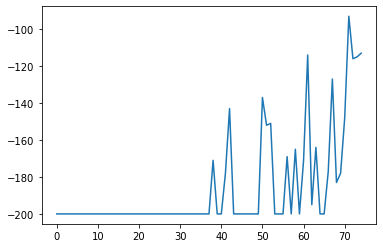

In [19]:
env = gym.make('MountainCar-v0')
env.seed(0)
#env = gym.wrappers.Monitor(env, "./records", video_callable=lambda _:True)

agent = SARSALambdaAgent(env)  

episodes = 75
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True)
    episode_rewards.append(episode_reward)
    
plt.plot(episode_rewards);

In [21]:
episodes = 5
episode_rewards = []
for episode in range(episodes):
    episode_reward = play_sarsa(env, agent, train=True, render=True)
    episode_rewards.append(episode_reward)
env.close()